In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [19]:
data = pd.read_csv('/content/final_dataset_new (1).csv')

<ipython-input-19-bf8770bad04f>:1: DtypeWarning: Columns (0,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/final_dataset_new (1).csv')


<ipython-input-20-ad639e808d1b>:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(2, 'Total_Order_Value'))
<ipython-input-20-ad639e808d1b>:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(2, 'Total_Order_Value'))


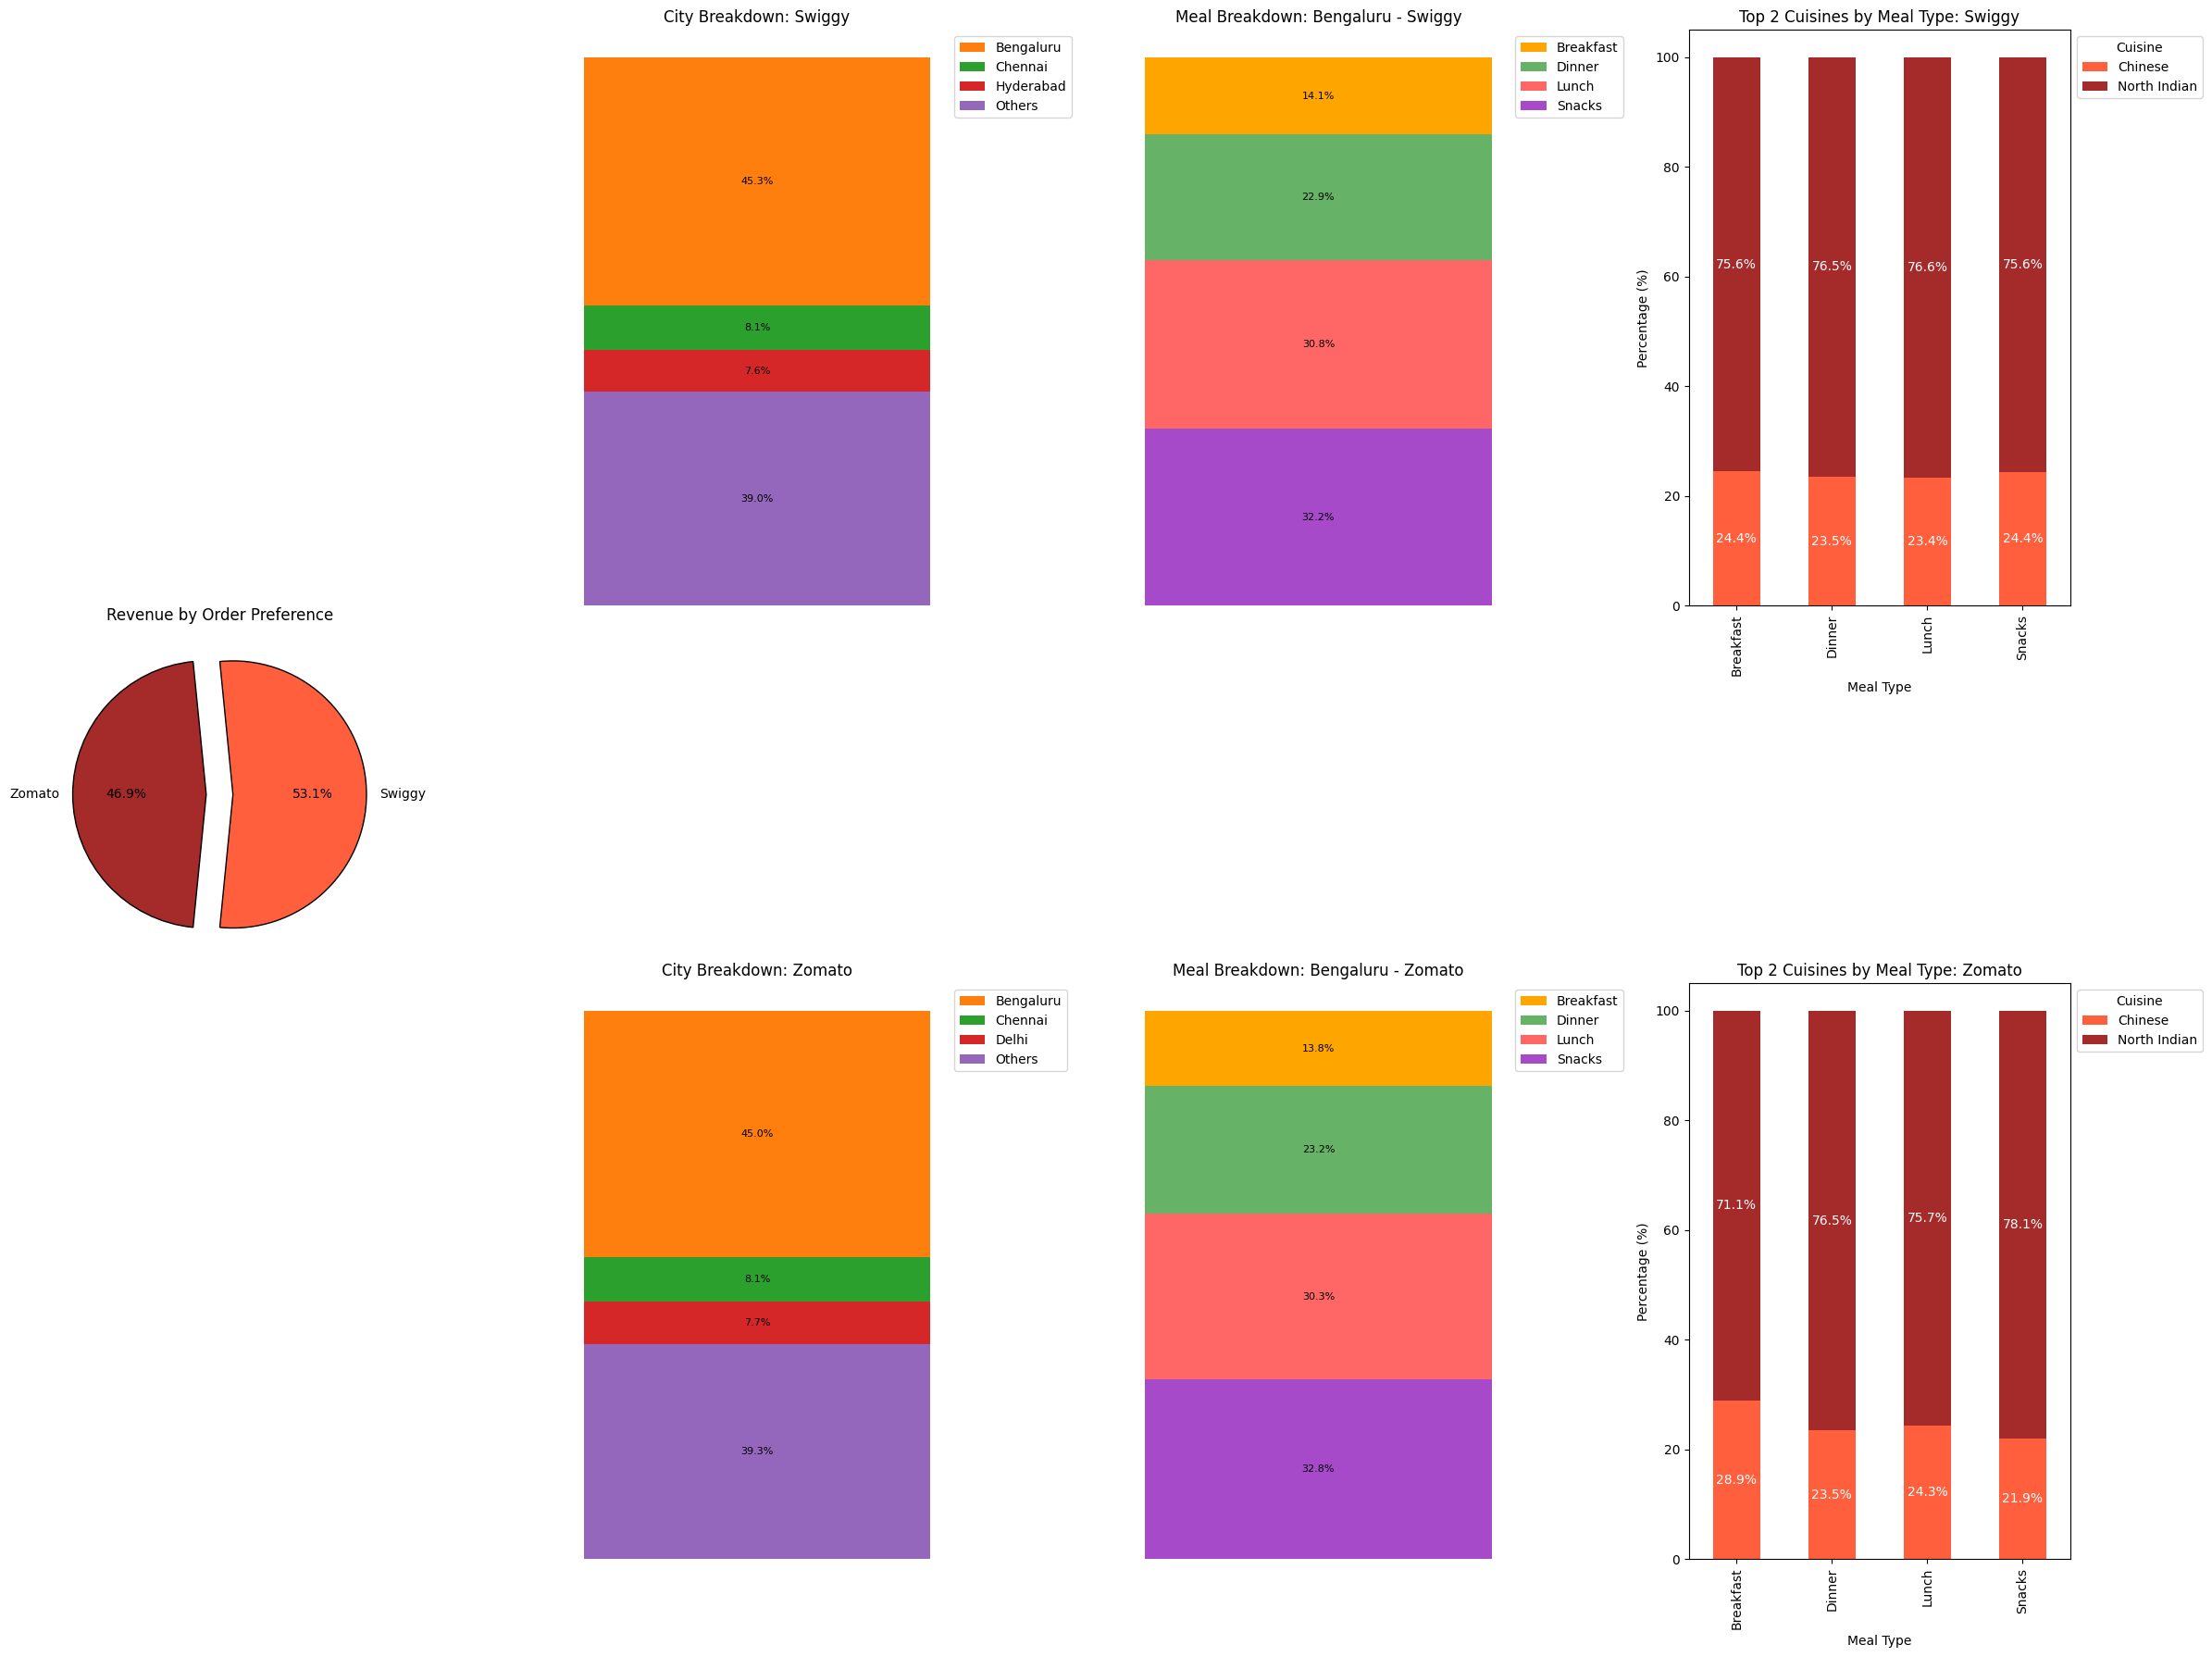

In [20]:
# Data preprocessing: Calculate revenue percentages by order preference and city breakdown
data['Total_Order_Value'] = pd.to_numeric(data['Total_Order_Value'], errors='coerce')
filtered_data = data[['City', 'Order_Preference', 'Total_Order_Value', 'Meal_Type', 'Cuisine']].dropna()

# Standardize city names (combine Bengaluru and Bangalore)
filtered_data['City'] = filtered_data['City'].replace({'Bangalore': 'Bengaluru'})

# Calculate revenue percentages by order preference
order_pref_revenue = filtered_data.groupby('Order_Preference')['Total_Order_Value'].sum()
order_pref_percentage = (order_pref_revenue / order_pref_revenue.sum()) * 100

# Function to process data for a given order preference
def process_order_preference(filtered_data, order_pref, color):
    data_pref = filtered_data[filtered_data['Order_Preference'] == order_pref]
    city_breakdown = data_pref.groupby('City')['Total_Order_Value'].sum().sort_values(ascending=False)
    top3_cities = city_breakdown[:3]
    others = city_breakdown[3:].sum()
    city_breakdown_final = pd.concat([top3_cities, pd.Series(others, index=['Others'])])
    city_percentage = (city_breakdown_final / city_breakdown_final.sum()) * 100

    # Most popular city analysis
    most_popular_city = city_breakdown.idxmax()
    most_popular_city_data = data_pref[data_pref['City'] == most_popular_city]

    # Meal type breakdown
    meal_type_revenue = most_popular_city_data.groupby('Meal_Type')['Total_Order_Value'].sum()
    meal_type_percentage = (meal_type_revenue / meal_type_revenue.sum()) * 100

    # Top 2 cuisines by meal type
    meal_cuisine_revenue = most_popular_city_data.groupby(['Meal_Type', 'Cuisine'])['Total_Order_Value'].sum().reset_index()
    top_cuisines_by_meal_percentage = (
        meal_cuisine_revenue.groupby('Meal_Type')
        .apply(lambda x: x.nlargest(2, 'Total_Order_Value'))
        .reset_index(drop=True)
    )
    pivot_data = top_cuisines_by_meal_percentage.pivot_table(
        index='Meal_Type', columns='Cuisine', values='Total_Order_Value', aggfunc='sum', fill_value=0
    )
    pivot_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

    return city_percentage, meal_type_percentage, pivot_percentage, color, order_pref

# Process data for Swiggy and Zomato
swiggy_results = process_order_preference(filtered_data, 'Swiggy', '#FF5F3D')
zomato_results = process_order_preference(filtered_data, 'Zomato', '#A52A2A')

# Create the figure and grid layout
fig = plt.figure(figsize=(24, 18))
gs = gridspec.GridSpec(3, 4, figure=fig, width_ratios=[0.35, 0.4, 0.4, 0.4], height_ratios=[0.1, 0.03, 0.1])

# Pie chart for order preference on the extreme left
ax_pie = fig.add_subplot(gs[:, 0])  # Use all rows in the first column
pie_sizes = order_pref_percentage.values
order_pref_labels = order_pref_percentage.index
explode = [0.1 if label in ['Swiggy', 'Zomato'] else 0 for label in order_pref_labels]
colors = ['#FF5F3D' if label == 'Swiggy' else '#A52A2A' if label == 'Zomato' else 'gray' for label in order_pref_labels]
angle = -180 * (order_pref_percentage['Swiggy'] / 100)
wedges, *_ = ax_pie.pie(
    pie_sizes, labels=order_pref_labels, autopct='%1.1f%%', startangle=angle,
    explode=explode, wedgeprops={"edgecolor": "black"}, colors=colors)
ax_pie.set_title("Revenue by Order Preference")

# Function to plot the charts for Swiggy and Zomato
def plot_order_pref(ax_city, ax_meal, ax_cuisine, results, order_pref):
    city_percentage, meal_type_percentage, pivot_percentage, _, _ = results

    # City Breakdown
    bottom_city = 1
    width = 0.2
    for i, (city, percentage) in enumerate(city_percentage.items()):
        bottom_city -= percentage / 100
        bar = ax_city.bar(0, percentage / 100, width, bottom=bottom_city, label=city, color=f'C{i+1}')
        ax_city.bar_label(bar, labels=[f"{percentage:.1f}%"], label_type='center', fontsize=8)
    ax_city.set_title(f"City Breakdown: {order_pref}")
    ax_city.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax_city.axis('off')

    # Meal Type Breakdown
    bottom_meal = 1
    colors = ["#FFA500", "#66B266", "#FF6666", "#A64AC9"]  # Define your colors list
    for i, (meal_type, percentage) in enumerate(meal_type_percentage.items()):
        bottom_meal -= percentage / 100
        bar = ax_meal.bar(0, percentage / 100, width, bottom=bottom_meal, label=meal_type, color=colors[i % len(colors)])
        ax_meal.bar_label(bar, labels=[f"{percentage:.1f}%"], label_type='center', fontsize=8)
    ax_meal.set_title(f"Meal Breakdown: Bengaluru - {order_pref}")
    ax_meal.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax_meal.axis('off')

    # Top 2 Cuisines
    pivot_percentage.plot(kind='bar', stacked=True, ax=ax_cuisine, color=['#FF5F3D', '#A52A2A'])
    ax_cuisine.set_title(f"Top 2 Cuisines by Meal Type: {order_pref}")
    ax_cuisine.set_ylabel('Percentage (%)')
    ax_cuisine.set_xlabel('Meal Type')
    ax_cuisine.legend(title='Cuisine', loc='upper left', bbox_to_anchor=(1, 1))

    # Add percentage labels on the cuisine chart
    for p in ax_cuisine.patches:
        height = p.get_height()
        if height > 0:  # Only label non-zero patches
            width = p.get_width()
            x = p.get_x() + width / 2
            y = p.get_y() + height / 2
            ax_cuisine.text(x, y, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='white')

# Top row for Swiggy
ax_city_swiggy = fig.add_subplot(gs[0, 1])
ax_meal_swiggy = fig.add_subplot(gs[0, 2])
ax_cuisine_swiggy = fig.add_subplot(gs[0, 3])
plot_order_pref(ax_city_swiggy, ax_meal_swiggy, ax_cuisine_swiggy, swiggy_results, "Swiggy")

# Bottom row for Zomato
ax_city_zomato = fig.add_subplot(gs[2, 1])
ax_meal_zomato = fig.add_subplot(gs[2, 2])
ax_cuisine_zomato = fig.add_subplot(gs[2, 3])
plot_order_pref(ax_city_zomato, ax_meal_zomato, ax_cuisine_zomato, zomato_results, "Zomato")

# Remove unused middle row to align pie chart with Swiggy and Zomato rows
fig.delaxes(fig.add_subplot(gs[1, 1]))
fig.delaxes(fig.add_subplot(gs[1, 2]))
fig.delaxes(fig.add_subplot(gs[1, 3]))

# Display the plot
plt.tight_layout()
plt.show()
